# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>


## Анализ временных рядов, часть 1


В данной задаче вы будете работать с данными температуре воздуха. Таблица содержит данные погоды примерно за 5 лет для городов США, Канады и Израиля. 
Файл `temperature.csv` содержит температуру в градусах Кельвина.




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

Загрузите таблицу. Обратиет внимание на параметр `parse_dates`, он используется для приведения столбца с датами к правильному типу данных.

In [2]:
df = pd.read_csv('temperature.csv', parse_dates=['datetime'])


Установим дату как индекс

In [3]:
df = df.set_index('datetime')
df.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


Посмотрим, как выглядят наши данные.

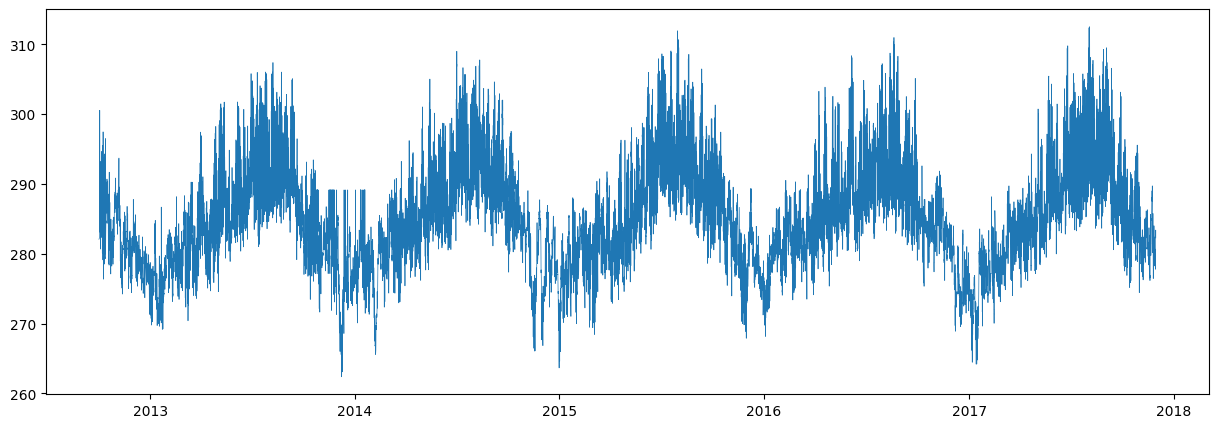

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['Portland'], lw=0.5);

Какие закономерности вы видите на графике?

**Ответ:** Видим сезонность: то есть периодичный набор трендов на повышение и снижение. Максимумы температур приходятся на летний сезон, минимумы на зимний. Отсутствует долгосрочный тренд, то есть средняя температура не меняется из года в год.

Посчитайте пропуски для каждого из городов.

In [9]:
df.isna().sum()

Vancouver            795
Portland               1
San Francisco        793
Seattle                3
Los Angeles            3
San Diego              1
Las Vegas              1
Phoenix                3
Albuquerque            1
Denver                 1
San Antonio            1
Dallas                 4
Houston                3
Kansas City            1
Minneapolis           13
Saint Louis            1
Chicago                3
Nashville              2
Indianapolis           7
Atlanta                6
Detroit                1
Jacksonville           1
Charlotte              3
Miami                805
Pittsburgh             3
Toronto                1
Philadelphia           3
New York             793
Montreal               3
Boston                 3
Beersheba            798
Tel Aviv District    793
Eilat                792
Haifa                798
Nahariyya            797
Jerusalem            793
dtype: int64

Выберите город с наименьшим количеством пропусков. Назовем этот город X.

In [12]:
X = df["Portland"][1:]
X

datetime
2012-10-01 13:00:00    282.080000
2012-10-01 14:00:00    282.083252
2012-10-01 15:00:00    282.091866
2012-10-01 16:00:00    282.100481
2012-10-01 17:00:00    282.109095
                          ...    
2017-11-29 20:00:00    282.000000
2017-11-29 21:00:00    282.890000
2017-11-29 22:00:00    283.390000
2017-11-29 23:00:00    283.020000
2017-11-30 00:00:00    282.280000
Name: Portland, Length: 45252, dtype: float64

Если данные имеют пропуски в начале или в конце, то лучше обрезать данные. Остальные пропуски стоит заполнить предыдущим значением по дате. Для этого вам может помочь функция `pandas.DataFrame.fillna`.

In [13]:
X.isna().sum()

0

Для города X будем предсказывать температуру с помощью моделей машинного обучения.


Разбейте данные на обучение и тест. Для тестовой выборки используйте последние **365 дней** из данных (не забывайте, что в данных представлены показатели за каждый час).


In [14]:
train = X[:45252 - 365 * 24]
test = X[45252 - 365 * 24:]

С форматом даты модели работать не умеют, поэтому нам необходимо описать дату признаками. Сделаем преобразование даты в признаки. 

In [15]:
def create_date_features(date):
    """Создает фичи из даты"""
    row = {}
    row["dayofweek"] = date.dayofweek 
    row["quarter"] = date.quarter 
    row["month"] = date.month 
    row["year"] = date.year 
    row["dayofyear"] = date.dayofyear 
    row["dayofmonth"] = date.day 
    row["weekofyear"] = date.weekofyear 
    return row

def create_only_date_train_features(y_series): 
    """
    Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    time_features = pd.DataFrame(
    [create_date_features(date) for date in y_series.index] )
    return time_features, y_series

In [16]:
X_train, y_train = create_only_date_train_features(train)
X_test, y_test = create_only_date_train_features(test)

In [18]:
X_train
y_train

datetime
2012-10-01 13:00:00    282.080000
2012-10-01 14:00:00    282.083252
2012-10-01 15:00:00    282.091866
2012-10-01 16:00:00    282.100481
2012-10-01 17:00:00    282.109095
                          ...    
2016-11-29 20:00:00    282.430000
2016-11-29 21:00:00    282.410000
2016-11-29 22:00:00    283.120000
2016-11-29 23:00:00    283.970000
2016-11-30 00:00:00    284.150000
Name: Portland, Length: 36492, dtype: float64

Постройте и обучите три модели: 
* модель линейной регрессии 
* решающего дерева
* случайного леса.

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

dtr = DecisionTreeRegressor(random_state=207)
dtr.fit(X_train, y_train)
y_dtr = dtr.predict(X_test)

rfr = RandomForestRegressor(random_state=207)
rfr.fit(X_train, y_train)
y_rfr = rfr.predict(X_test)

Посчитайте качество на тесте (MSE, MAE, MAPE).



In [20]:
print(f"MSE lr {mean_squared_error(y_test, y_lr)}",
      f"MAE lr {mean_absolute_error(y_test, y_lr)}"
      f"MAPE lr {mean_absolute_percentage_error(y_test, y_lr)}"
      )
print(f"MSE dtr {mean_squared_error(y_test, y_dtr)}",
      f"MAE dtr {mean_absolute_error(y_test, y_dtr)}"
      f"MAPE dtr {mean_absolute_percentage_error(y_test, y_dtr)}"
      )
print(f"MSE rfr {mean_squared_error(y_test, y_rfr)}",
      f"MAE rfr {mean_absolute_error(y_test, y_rfr)}"
      f"MAPE rfr {mean_absolute_percentage_error(y_test, y_rfr)}"
      )

MSE lr 63.203843162045324 MAE lr 6.797180346393921MAPE lr 0.024027289373582256
MSE dtr 34.14145880448325 MAE dtr 4.599206170446315MAPE dtr 0.016098888484503655
MSE rfr 30.593765252024813 MAE rfr 4.327454468023355MAPE rfr 0.015142646724064759


Визуализируйте результат.

In [21]:
def plot_results(y_to_train, y_to_test, y_forecast): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series
            Временной ряд, который предсказывает модель.
        - y_forecast: array
            Предсказания модели.
        - plot_conf_int: bool
            Надо ли строить предсказательного интервал.
        - left_bound: array
            Левая граница предсказательного интервала.
        - right_bound: array
            Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.title("Показатели температуры для города Х", fontsize=15) 
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction") 
    plt.legend()
    plt.show()

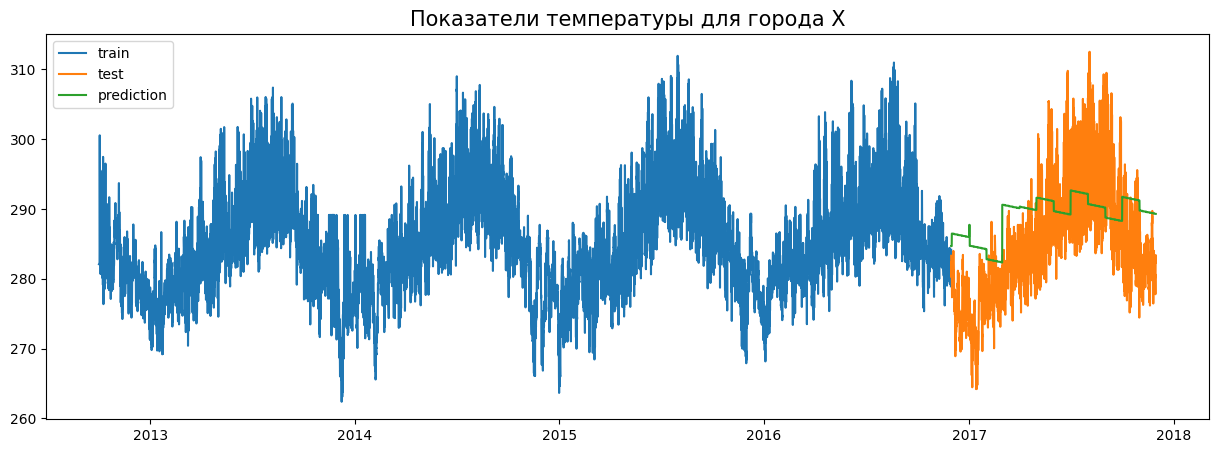

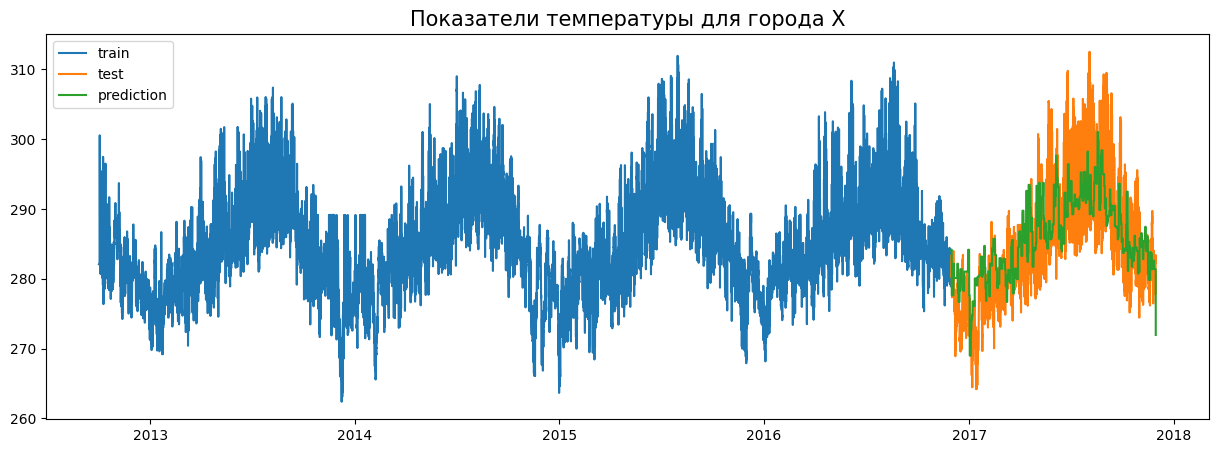

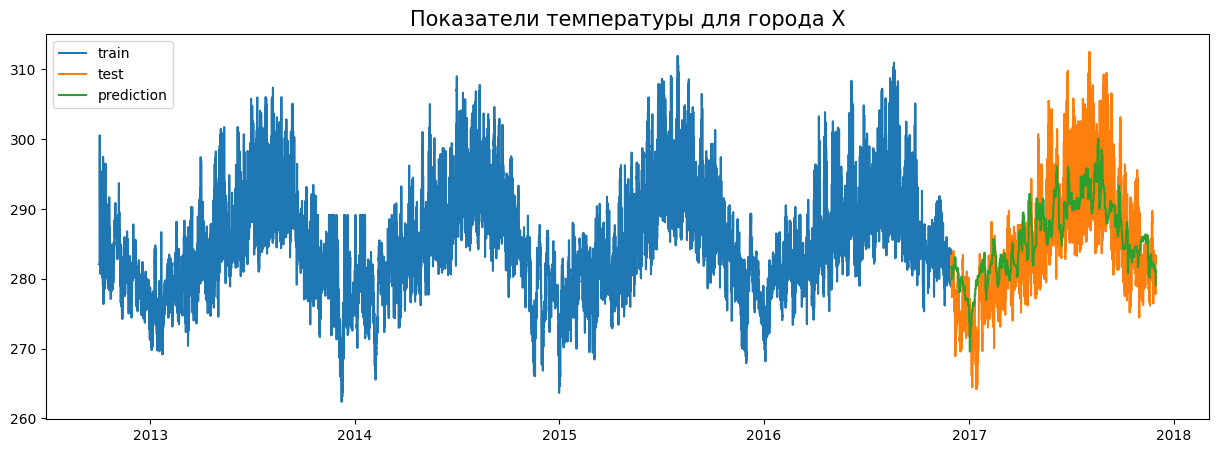

In [23]:
plot_results(y_train, y_test, y_lr)
plot_results(y_train, y_test, y_dtr)
plot_results(y_train, y_test, y_rfr)

Сделайте выводы.

**Вывод:** Исходя из метрик, решающее дерево и случайный лес показывают результаты лучше, чем модель линейной регрессии. Лучше всего с этим справился случайный лес показав ошибку на тесте: 1.5%. Из графиков видно, что предсказание модели линейной регрессии ужасное, в то время как предсказания решающего дерева и рандомного леса имеют схожее поведение с тестом